In [1]:
# basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hour, day, MW, kg, lb, kWh, MWh
import sys
import time

# osier imports
from osier import CapacityExpansion
import osier.tech_library as lib
from osier.equations import total_cost, annual_emission, annual_co2
from osier import get_tech_names
from osier import technology_dataframe

# import megatonnes from unyt -- must be done after importing osier
from unyt import megatonnes
import dill as pickle

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.pcp import PCP
from functools import partial
from pymoo.termination.max_gen import MaximumGenerationTermination
from pymoo.indicators.hv import HV


from time import sleep

# set the solver based on operating system -- assumes glpk or cbc is installed.
if "win32" in sys.platform:
    solver = 'glpk'
elif "linux" in sys.platform:
    solver = "appsi_highs"
else:
    solver = "appsi_highs"

print(f"Solver set: {solver}")

Solver set: appsi_highs


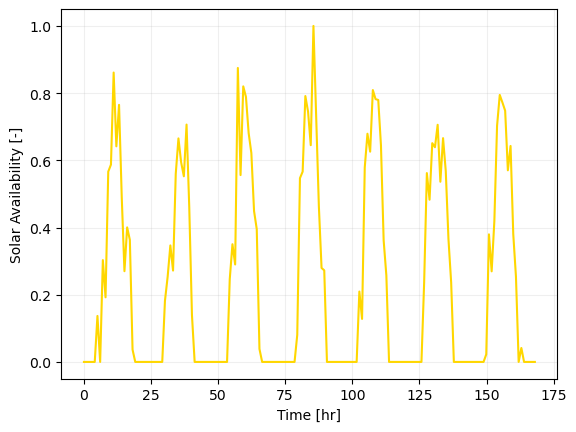

In [2]:
n_hours = 24  # hours per day
n_days = 7  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = np.pi/2  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)

solar_cp = (-np.sin((hours*np.pi/n_hours*2+phase_shift)))
# solar[solar<0] = 0

rng = np.random.default_rng(1234)

solar_cp += rng.normal(size=N)*15e-2
solar_cp[solar_cp<0] = 0

solar_cp = solar_cp/solar_cp.max()  # rescale


demand = np.ones(N)*1e3*MW
# print(demand)


# with plt.style.context("dark_background"):
#     plt.plot(hours, solar_cp, color='gold')
#     plt.ylabel('Solar Availability [-]')
#     plt.xlabel('Time [hr]')
#     plt.grid(alpha=0.2)
#     plt.show()


plt.plot(hours, solar_cp, color='gold')
plt.ylabel('Solar Availability [-]')
plt.xlabel('Time [hr]')
plt.grid(alpha=0.2)
plt.show()

In [3]:
peak_demand = 1e3*MW 
demand = np.ones(N)*peak_demand

In [4]:
natural_gas = lib.natural_gas
natural_gas_adv = lib.natural_gas_adv
nuclear_ap1000 = lib.nuclear
nuclear_smr = lib.nuclear_adv
solar = lib.solar
battery = lib.battery

In [5]:
emission_df = pd.read_html("https://www.eia.gov/tools/faqs/faq.php?id=74&t=11")[0].droplevel(1, axis=1).set_index('Unnamed: 0_level_0').iloc[:-1,:-2]
emission_df.columns = ['Total kWh', 'Total CO2 million mt', 'million short tons','lbs per kWh']
emission_df.index.name = ''
emission_df

,Total kWh,Total CO2 million mt,million short tons,lbs per kWh
,,,,
Coal,675115,709,781,2.31
Natural gas,1806063,790,871,0.96
Petroleum,16233,18,20,2.46
All other energy sources,4183271,1532,1688,0.81


In [6]:
eroi_df = pd.read_csv("../../../data/eroi_data.csv", index_col=0)
eroi_df

,EROIstd
Generation method,
Natural Gas (CCGT),89.0
Natural Gas (CCGT & CCS),12.4
"Solar PV (Mono-Si, SE-med)",2.5
Nuclear (83% centrifuge),69.6
Nuclear (100% centrifuge),96.2


In [7]:
final_techs = {'Utility PV - Class 1':'UtilityPV', 
    'NG 1-on-1 Combined Cycle (H-Frame)':"Natural Gas",
    'NG 1-on-1 Combined Cycle (H-Frame) 95% CCS':"Natural Gas CCS",
    'Nuclear - Large':"Nuclear",
    'Nuclear - Small':"Advanced Nuclear",        
    'Utility-Scale Battery Storage - 4Hr':"Battery",
    }

In [8]:
cost_df = pd.read_csv("../../../data/technology_costs.csv", index_col=['core_metric_parameter','display_name'])
cost_df

value
core_metric_parameter display_name                 
Fixed O&M             UtilityPV           16.798551
CAPEX                 UtilityPV         1074.217024
Fixed O&M             Natural Gas         37.000000
                      Natural Gas CCS     66.100000
Variable O&M          Natural Gas          2.390000
                      Natural Gas CCS      4.620000
CAPEX                 Natural Gas       1645.344968
                      Natural Gas CCS   2916.043828
Fixed O&M             Nuclear            175.000000
                      Advanced Nuclear   136.000000
Variable O&M          Nuclear              2.800000
                      Advanced Nuclear     2.600000
CAPEX                 Nuclear           7486.164800
                      Advanced Nuclear  8935.185812
Fixed O&M             Battery             31.501211
CAPEX                 Battery           1409.745888

In [35]:
emission_df

,Total kWh,Total CO2 million mt,million short tons,lbs per kWh
,,,,
Coal,675115,709,781,2.31
Natural gas,1806063,790,871,0.96
Petroleum,16233,18,20,2.46
All other energy sources,4183271,1532,1688,0.81


In [9]:
# for a NG 1-on-1 H Frame design
natural_gas.co2_rate = (float(emission_df.at['Natural gas', 'lbs per kWh'])*lb/(kW*hour)).to(megatonnes/(MW*hour))
natural_gas.capital_cost = cost_df.at[('CAPEX','Natural Gas'), 'value'] / kW  / 1e6
natural_gas.om_cost_variable = cost_df.at[('Variable O&M','Natural Gas'), 'value'] / MWh / 1e6
natural_gas.om_cost_fixed = cost_df.at[('Fixed O&M','Natural Gas'), 'value'] / kW / 1e6
natural_gas.eroi = eroi_df.at['Natural Gas (CCGT)', 'EROIstd'] # from Walmsley et al.
# same design, with 95% CCS
natural_gas_adv.co2_rate = natural_gas.co2_rate * 0.05
natural_gas_adv.capital_cost = cost_df.at[('CAPEX','Natural Gas CCS'), 'value'] / kW / 1e6
natural_gas_adv.om_cost_variable = cost_df.at[('Variable O&M','Natural Gas CCS'), 'value'] / MWh / 1e6
natural_gas_adv.om_cost_fixed = cost_df.at[('Fixed O&M','Natural Gas CCS'), 'value'] / kW / 1e6
natural_gas_adv.eroi = eroi_df.at['Natural Gas (CCGT & CCS)', 'EROIstd'] # from Walmsley et al.

In [10]:
# utility scale solar, with good insolation, middling estimate
solar.capital_cost = cost_df.at[('CAPEX','UtilityPV'), 'value']/kW / 1e6
solar.eroi = eroi_df.at['Solar PV (Mono-Si, SE-med)', 'EROIstd'] # from Walmsley et al. 2018
solar.om_cost_fixed = cost_df.at[('Fixed O&M','UtilityPV'), 'value']/kW / 1e6
solar.co2_rate = 0*(megatonnes/(MW*hour))
solar.fuel_cost = 0/(MW*hour)

In [11]:
battery.capital_cost = cost_df.at[('CAPEX','Battery'), 'value'] / kW / 1e6
battery.om_cost_fixed = cost_df.at[('Fixed O&M','Natural Gas'), 'value']/ kW / 1e6
battery.eroi = 10  # actually an 'ESOI,' from Barnhart and Benson 2013
battery.co2_rate = 0*(megatonnes/(MW*hour))
battery.fuel_cost = 0/(MW*hour)


In [12]:
nuclear_ap1000.capital_cost = cost_df.at[('CAPEX','Nuclear'), 'value'] / kW / 1e6
nuclear_ap1000.om_cost_fixed = cost_df.at[('Fixed O&M','Nuclear'), 'value'] / kW / 1e6
nuclear_ap1000.om_cost_variable = cost_df.at[('Variable O&M','Nuclear'), 'value']/ MWh / 1e6
nuclear_ap1000.eroi = eroi_df.at['Nuclear (100% centrifuge)', 'EROIstd']
nuclear_ap1000.co2_rate = 0*(megatonnes/(MW*hour))

nuclear_smr.capital_cost = cost_df.at[('CAPEX','Advanced Nuclear'), 'value'] / kW / 1e6
nuclear_smr.om_cost_fixed = cost_df.at[('Fixed O&M','Advanced Nuclear'), 'value']/ kW / 1e6
nuclear_smr.om_cost_variable = cost_df.at[('Variable O&M','Advanced Nuclear'), 'value']/ MWh / 1e6
nuclear_smr.eroi = eroi_df.at['Nuclear (100% centrifuge)', 'EROIstd']
nuclear_smr.co2_rate = 0*(megatonnes/(MW*hour))

In [13]:
tech_list = [natural_gas, natural_gas_adv, solar, battery, nuclear_ap1000, nuclear_smr]

In [37]:
tech_data_df = technology_dataframe(tech_list, cast_to_string=True).T.iloc[[13,14,15,16, 17, 21, ],:]

In [55]:
tech_data_df

technology_name,NaturalGas_Conv,NaturalGas_Adv,SolarPanel,Battery,Nuclear,Nuclear_Adv
capital cost (1/kW),0.00165,0.00292,0.00107,0.00141,0.00749,0.00894
om cost fixed (1/kW),3.7e-05,6.61e-05,1.68e-05,3.7e-05,0.000175,0.000136
om cost variable (1/MWh),2.39e-06,4.62e-06,0,0,2.8e-06,2.6e-06
fuel cost (1/(MW*hr)),2.24e-05,2.75e-05,0,0,5.81e-06,9.16e-06
co2 rate (megatonnes/(MW*hr)),4.35e-07,2.18e-08,0,0,0,0
eroi,89,12.4,2.5,10,96.2,96.2


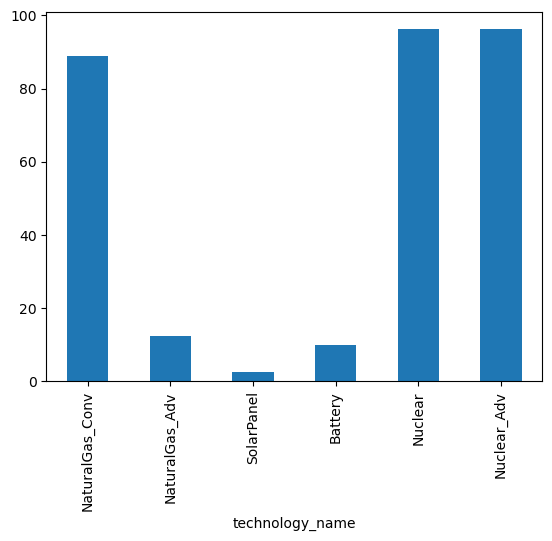

In [ ]:

for column in tech_data_df.T:

ax = tech_data_df.T['eroi'].plot(kind='bar')
# ax.set_yscale('log')

In [16]:
tech_data_df.style.format(precision=2).to_latex(hrules=True)

'\\begin{tabular}{lllllll}\n\\toprule\ntechnology_name & NaturalGas_Conv & NaturalGas_Adv & SolarPanel & Battery & Nuclear & Nuclear_Adv \\\\\n\\midrule\ncapital_cost (1/kW) & 0.00165 & 0.00292 & 0.00107 & 0.00141 & 0.00749 & 0.00894 \\\\\nom_cost_fixed (1/kW) & 3.7e-05 & 6.61e-05 & 1.68e-05 & 3.7e-05 & 0.000175 & 0.000136 \\\\\nom_cost_variable (1/MWh) & 2.39e-06 & 4.62e-06 & 0 & 0 & 2.8e-06 & 2.6e-06 \\\\\nfuel_cost (1/(MW*hr)) & 2.24e-05 & 2.75e-05 & 0 & 0 & 5.81e-06 & 9.16e-06 \\\\\nco2_rate (megatonnes/(MW*hr)) & 4.35e-07 & 2.18e-08 & 0 & 0 & 0 & 0 \\\\\neroi & 89 & 12.4 & 2.5 & 10 & 96.2 & 96.2 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [17]:
def eroi_objective(technology_list, solved_dispatch_model):
    """
    Calculate the objective to ``maximize'' the Energy Return on Investment (EROI)
    by minimizing its inverse.
    """
    weighted_eroi = np.array([t.capacity.to_value() * t.eroi for t in technology_list]).sum()
    obj_value = 1/weighted_eroi
    return obj_value

In [18]:
problem = CapacityExpansion(technology_list=tech_list,
                            demand=demand,
                            solar=solar_cp,
                            upper_bound = 1 / solar.capacity_credit,
                            objectives = [total_cost, 
                                         partial(annual_emission, emission='co2_rate'),
                                         eroi_objective],
                            solver=solver
                            )

In [21]:
import os
from glob import glob

In [24]:
glob("checkpoint_*.pkl")

['checkpoint_20250622-103907.pkl', 'checkpoint_20250622-104151.pkl']

In [20]:
if 'checkpoint.pkl' in os.listdir():
    print("True")
else:
    print("False")

False


In [ ]:
algorithm = NSGA2(pop_size=100)
algorithm.termination = MaximumGenerationTermination(5)
try:
    checkpoint_list = glob("checkpoint_*.pkl")
    if len(checkpoint_list) > 0:
        with open(checkpoint_list[-1], 'rb') as f:
            checkpoint = pickle.load(f)
            print("Loaded Checkpoint:", checkpoint)
        res = minimize(problem,
                        checkpoint,
                        seed=1,
                        copy_algorithm=False,
                        save_history=True,
                        verbose=True)
    else:
        print("No checkpoints found. Starting new run.")
        res = minimize(problem,
                    algorithm,
                    seed=1,
                    copy_algorithm=False,
                    save_history=True,
                    verbose=True)
except KeyboardInterrupt:
    timestr = time.strftime("%Y%m%d-%H%M%S")
    checkpoint_name = f"checkpoint_{timestr}.pkl"
    with open(checkpoint_name, "wb") as f:
        pickle.dump(algorithm, f)


# only necessary if for the checkpoint the termination criterion has been met
# checkpoint.termination = MaximumGenerationTermination(20)


Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x30a20e330>


In [ ]:
ref_point = np.array([6e9, 1, 1])

ind = HV(ref_point=ref_point)

performance_list = []
for pop in res.history:
    pop_pf = np.array([e.F for e in pop.opt])
    performance_list.append(ind(pop_pf))

n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, performance_list, "--")
# plt.yscale("log")
plt.show()

In [61]:
algorithm.termination

In [ ]:
res = minimize(problem,
               ,
               seed=1,
               copy_algorithm=False,
               verbose=True)

KeyboardInterrupt: 

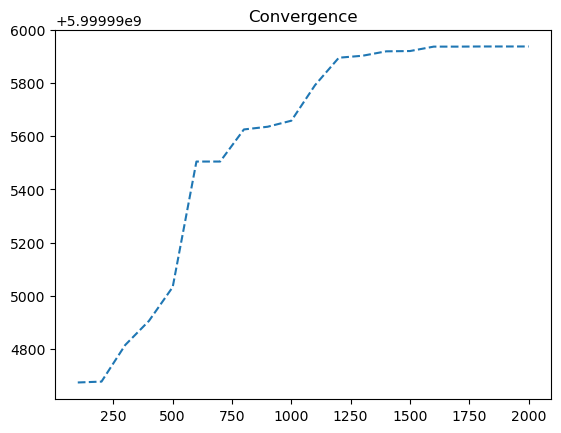

In [136]:
performance_list = []
for pop in res.history:
    pop_pf = np.array([e.F for e in pop.opt])
    performance_list.append(ind(pop_pf))

n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, performance_list, "--")
# plt.yscale("log")
plt.show()

In [157]:
checkpoint_name = "checkpoint_4.pkl"
with open(checkpoint_name, "wb") as f:
    pickle.dump(checkpoint, f)

with open(checkpoint_name, 'rb') as f:
    checkpoint = pickle.load(f)
    print("Loaded Checkpoint:", checkpoint)

Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x624f910a0>


In [158]:
checkpoint.termination = MaximumGenerationTermination(120)

    81 |     8100 |    100 |  0.0087660863 |             f
    82 |     8200 |    100 |  0.0066361664 |             f
    83 |     8300 |    100 |  0.0082566453 |             f
    84 |     8400 |    100 |  0.0066661440 |             f
    85 |     8500 |    100 |  0.0107207739 |             f
    86 |     8600 |    100 |  0.0062448009 |             f
    87 |     8700 |    100 |  0.0055754834 |             f
    88 |     8800 |    100 |  0.0099746728 |             f
    89 |     8900 |    100 |  0.0054270880 |         nadir
    90 |     9000 |    100 |  0.0039706343 |             f
    91 |     9100 |    100 |  0.0039661997 |             f
    92 |     9200 |    100 |  0.0078698600 |             f
    93 |     9300 |    100 |  0.0113222545 |         nadir
    94 |     9400 |    100 |  0.0096127579 |             f
    95 |     9500 |    100 |  0.0121055778 |             f
    96 |     9600 |    100 |  0.0048355787 |             f
    97 |     9700 |    100 |  0.0063581731 |            

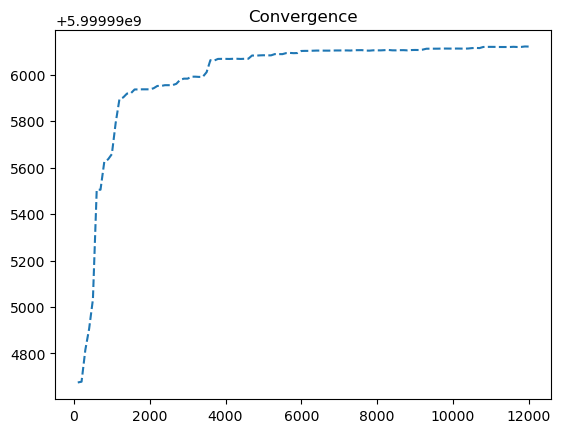

In [159]:
res = minimize(problem,
               checkpoint,
               seed=1,
               copy_algorithm=False,
               verbose=True)

performance_list = []
for pop in res.history:
    pop_pf = np.array([e.F for e in pop.opt])
    performance_list.append(ind(pop_pf))

n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, performance_list, "--")
# plt.yscale("log")
plt.show()

In [106]:
import dill as pickle

In [160]:
with open("datacenter_results_120gen.pkl", "wb") as file:
    pickle.dump(res, file)

In [50]:
res.history[0].opt[0].F

array([2.43527318e+09, 6.53418380e-02, 9.97323442e-07])

In [ ]:
from pymoo.indicators.hv import HV

ref_point = np.array([6e9, 1, 1])

ind = HV(ref_point=ref_point)
# print("HV", ind(A))
ind(res.F)

5732101078.497424

In [103]:
performance_list = []
for pop in res.history:
    pop_pf = np.array([e.F for e in pop.opt])
    performance_list.append(ind(pop_pf))


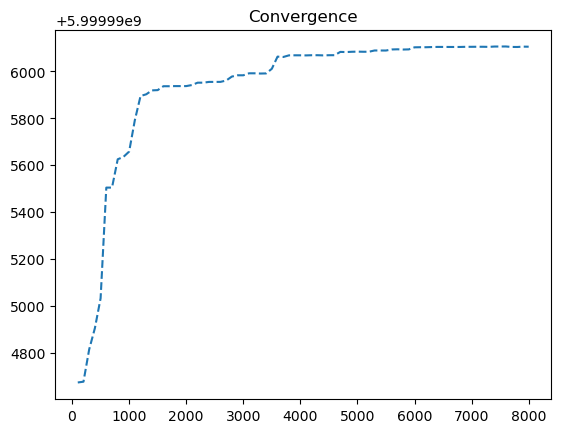

In [149]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, performance_list, "--")
# plt.yscale("log")
plt.show()

/Users/samdotson/miniforge3/envs/2025-dotson-thesis-2/lib/python3.12/site-packages/pymoo/core/plot.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**kwargs)


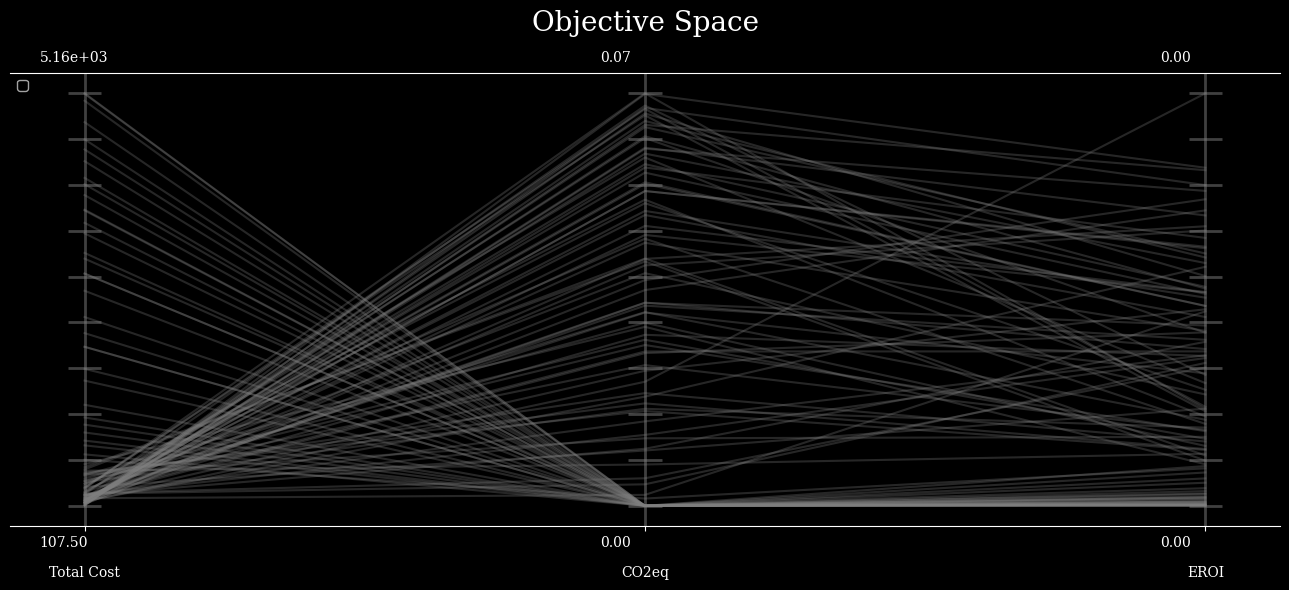

In [161]:
obj_labels=['Total Cost', 'CO2eq', 'EROI']
with plt.style.context('dark_background'):
    plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':20}),
            n_ticks=10,
            legend=(True, {'loc': "upper left"}),
            labels=obj_labels,
            figsize=(13,6),
            )

    plot.set_axis_style(color="grey", alpha=0.5)
    plot.tight_layout = True
    plot.add(res.F, color="grey", alpha=0.3)

    # plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    # plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
    plot.show()
    plt.show()

/Users/samdotson/miniforge3/envs/2025-dotson-thesis-2/lib/python3.12/site-packages/pymoo/core/plot.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**kwargs)


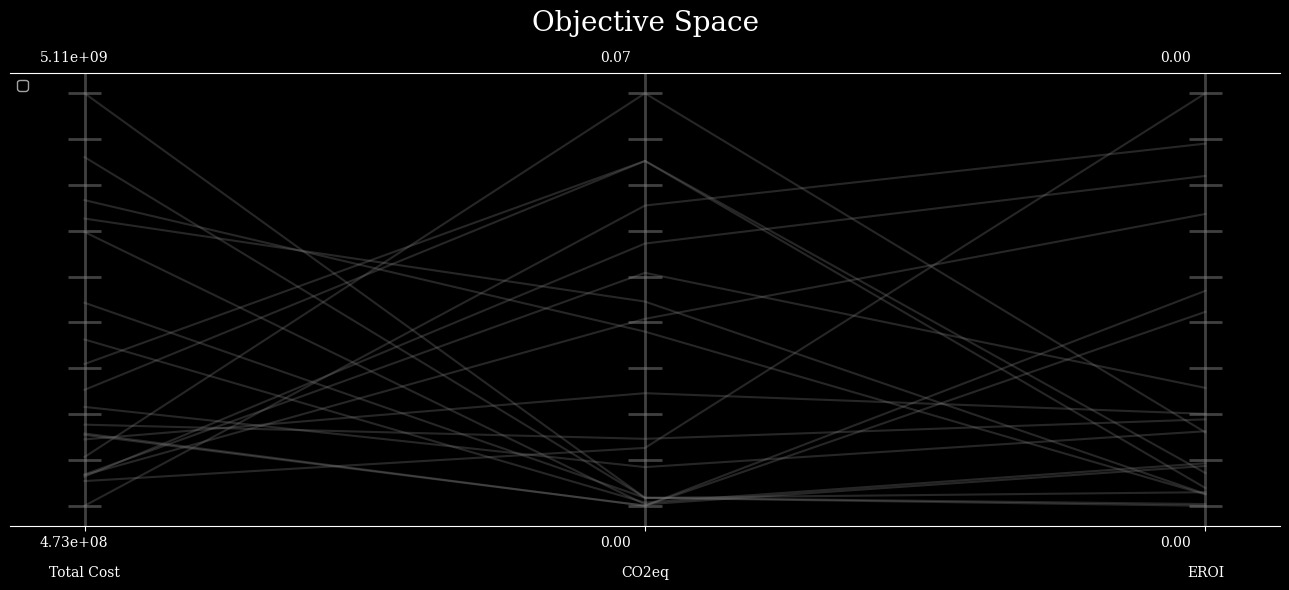

In [29]:
obj_labels=['Total Cost', 'CO2eq', 'EROI']
with plt.style.context('dark_background'):
    plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':20}),
            n_ticks=10,
            legend=(True, {'loc': "upper left"}),
            labels=obj_labels,
            figsize=(13,6),
            )

    plot.set_axis_style(color="grey", alpha=0.5)
    plot.tight_layout = True
    plot.add(res.F, color="grey", alpha=0.3)

    # plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    # plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
    plot.show()
    plt.show()

/Users/samdotson/miniforge3/envs/2025-dotson-thesis-2/lib/python3.12/site-packages/pymoo/core/plot.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**kwargs)


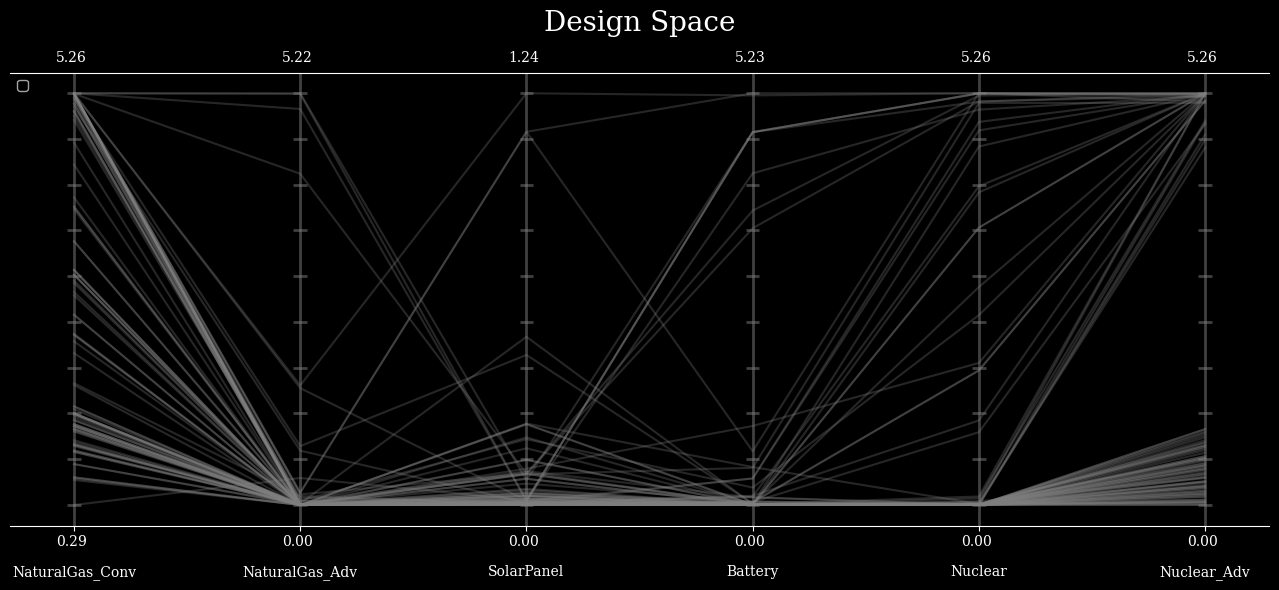

In [162]:
# obj_labels=['Total Cost', 'CO2eq', 'EROI']
obj_labels = get_tech_names(tech_list)
with plt.style.context('dark_background'):
    plot = PCP(title=("Design Space", {'pad': 30, 'fontsize':20}),
            n_ticks=10,
            legend=(True, {'loc': "upper left"}),
            labels=obj_labels,
            figsize=(13,6),
            )

    plot.set_axis_style(color="grey", alpha=0.5)
    plot.tight_layout = True
    plot.add(res.X, color="grey", alpha=0.3)

    # plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    # plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
    plot.show()
    plt.show()

NameError: name 'res' is not defined

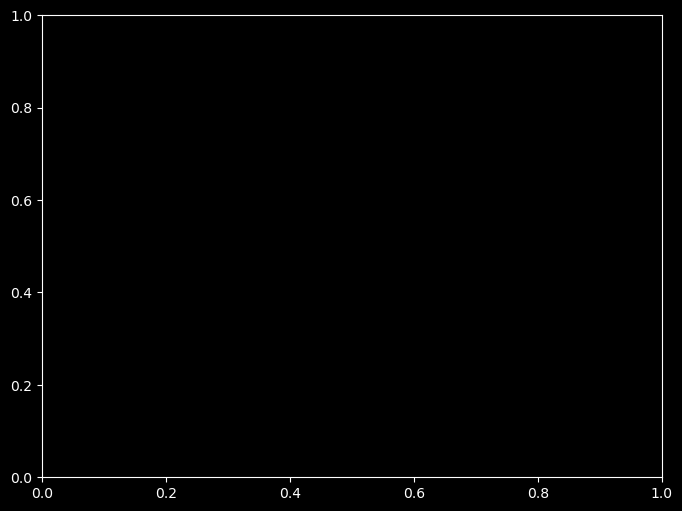

In [26]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(8,6))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       tick_labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'gold','gray','tab:green','olive']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

In [ ]:
technology_dataframe(tech_list, cast_to_string=True).T.reset_index()#.loc[[13,14,15,16, 17, 22, ],:]

technology_name,index,NaturalGas_Conv,NaturalGas_Adv,SolarPanel,Battery,Nuclear,Nuclear_Adv
0,technology_category,thermal,thermal,base,base,thermal,thermal
1,technology_type,production,production,production,storage,production,production
2,dispatchable,True,True,False,True,True,True
3,renewable,False,False,True,False,False,False
4,fuel_type,None,None,solar,None,None,None
5,ramp_up_rate (1/hr),1,1,NaN,NaN,0,0.25
6,ramp_down_rate (1/hr),1,1,NaN,NaN,0,0.25
7,lifetime,25,25,25,25,25,25
8,capacity (MW),8.38e+03,0,2.81e+03,815,1.86e+04,0
9,power_level (MW),8.38e+03,0,2.81e+03,815,1.86e+04,0


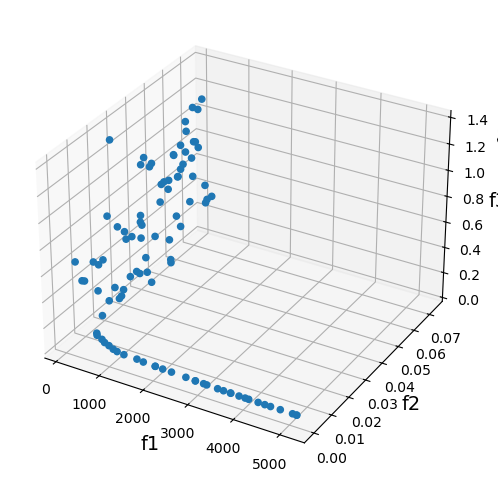

In [164]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
# ax.plot_trisurf(*zip(*res.F), alpha=1)
ax.scatter3D(*zip(*res.F), alpha=1)
# ax.view_init(azim=0, elev=90)
ax.set_xlabel('f1', fontsize=14, labelpad=2)
ax.set_ylabel('f2', fontsize=14, labelpad=2)
ax.set_zlabel('f3', fontsize=14, labelpad=2)
# plt.tight_layout()
plt.show()

In [122]:
with open("../../../../2023-osier-simulation-results/2023-05-30-NOBJ4-USNGA3-results.pkl", "rb") as file:
    old_results = pickle.load(file)

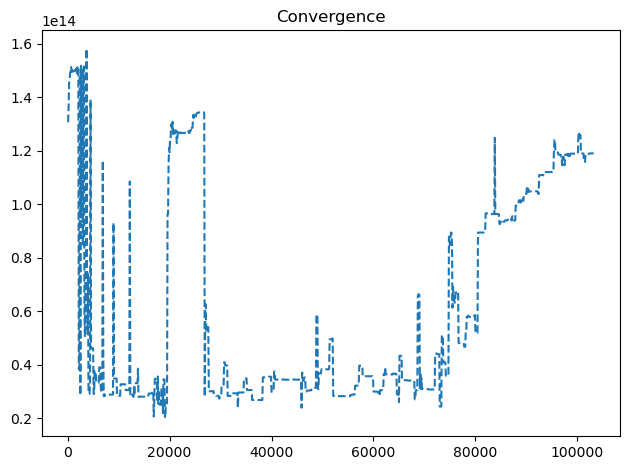

In [127]:
ref_point = np.array([2e6, 1e2, 1e6, 1.1])

ind = HV(ref_point=ref_point)

performance_list = []
for pop in old_results.history:
    pop_pf = np.array([e.F for e in pop.opt])
    performance_list.append(ind(pop_pf))


n_evals = np.array([e.evaluator.n_eval for e in old_results.history])

plt.title("Convergence")
plt.plot(n_evals, performance_list, "--")
# plt.yscale("log")
plt.tight_layout()
plt.show()